In [7]:
import matplotlib.pyplot as plt
import matplotlib

# 1️⃣ 한글 가능 폰트 설정 (macOS 기본 예시)
matplotlib.rcParams['font.family'] = 'AppleGothic'

# 2️⃣ 그래프에서 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


✅ 데이터 로드 완료

[결측치 확인]
                               orders items products translation
customer_id                       0.0     -        -           -
freight_value                       -   0.0        -           -
order_approved_at               160.0     -        -           -
order_delivered_carrier_date   1783.0     -        -           -
order_delivered_customer_date  2965.0     -        -           -
order_estimated_delivery_date     0.0     -        -           -
order_id                          0.0   0.0        -           -
order_item_id                       -   0.0        -           -
order_purchase_timestamp          0.0     -        -           -
order_status                      0.0     -        -           -
price                               -   0.0        -           -
product_category_name               -     -    610.0         0.0
product_category_name_english       -     -        -         0.0
product_description_lenght          -     -    610.0           -
pro

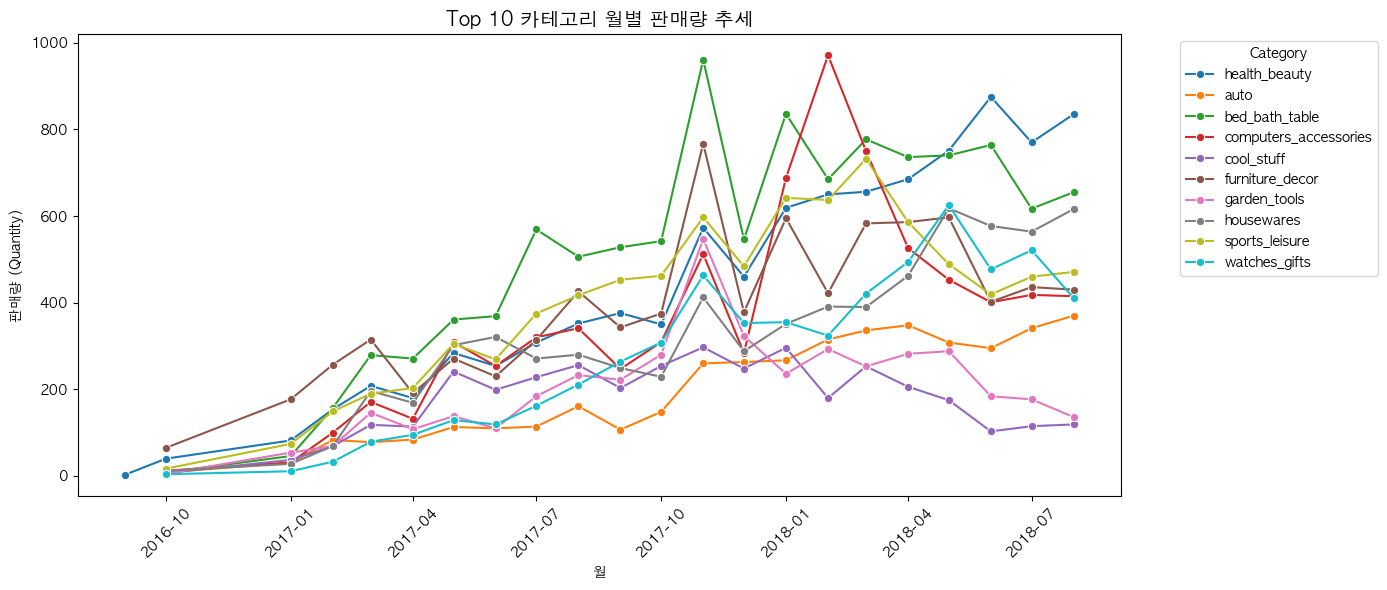

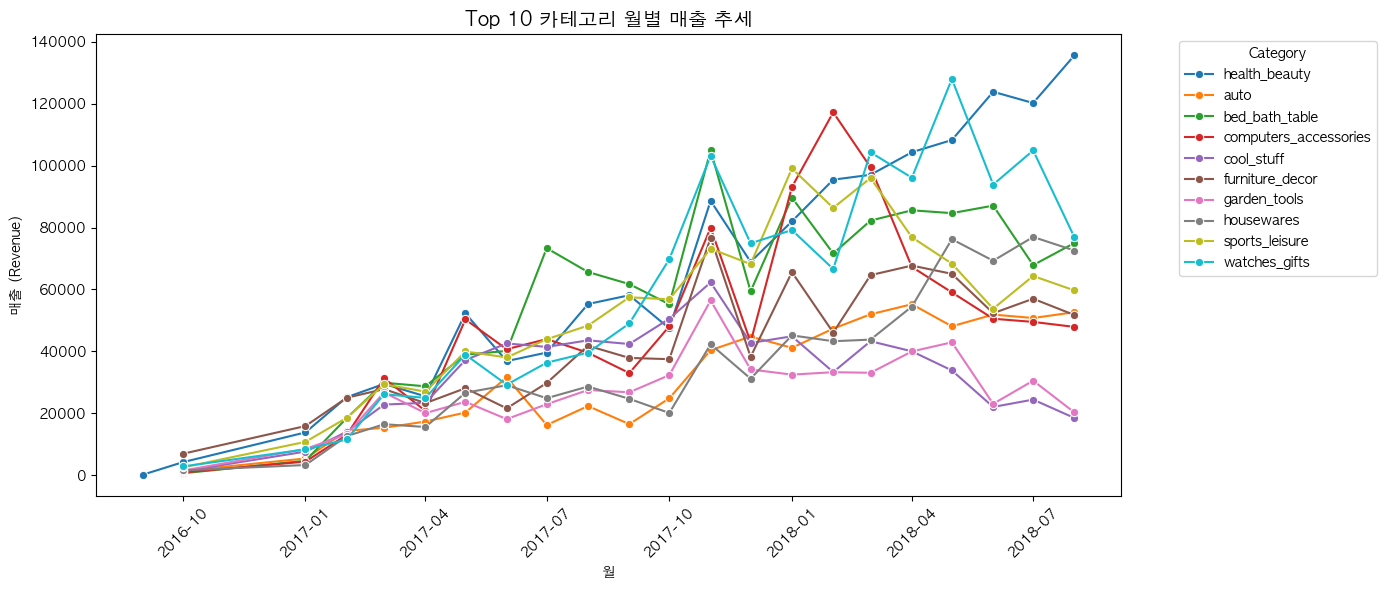

📈 성장 카테고리 TOP5: [('health_beauty', np.float64(6137.170959909656)), ('watches_gifts', np.float64(5373.5070649350655)), ('bed_bath_table', np.float64(3907.4770779220776)), ('housewares', np.float64(3512.6937792207796)), ('sports_leisure', np.float64(3380.236025974026))]
📉 하락 카테고리 TOP5: [('computers', np.float64(-1004.0134065934069)), ('market_place', np.float64(-60.94031168831169)), ('tablets_printing_image', np.float64(-58.95191176470589)), ('cds_dvds_musicals', np.float64(-30.05571428571428)), ('flowers', np.float64(-24.31416666666666))]


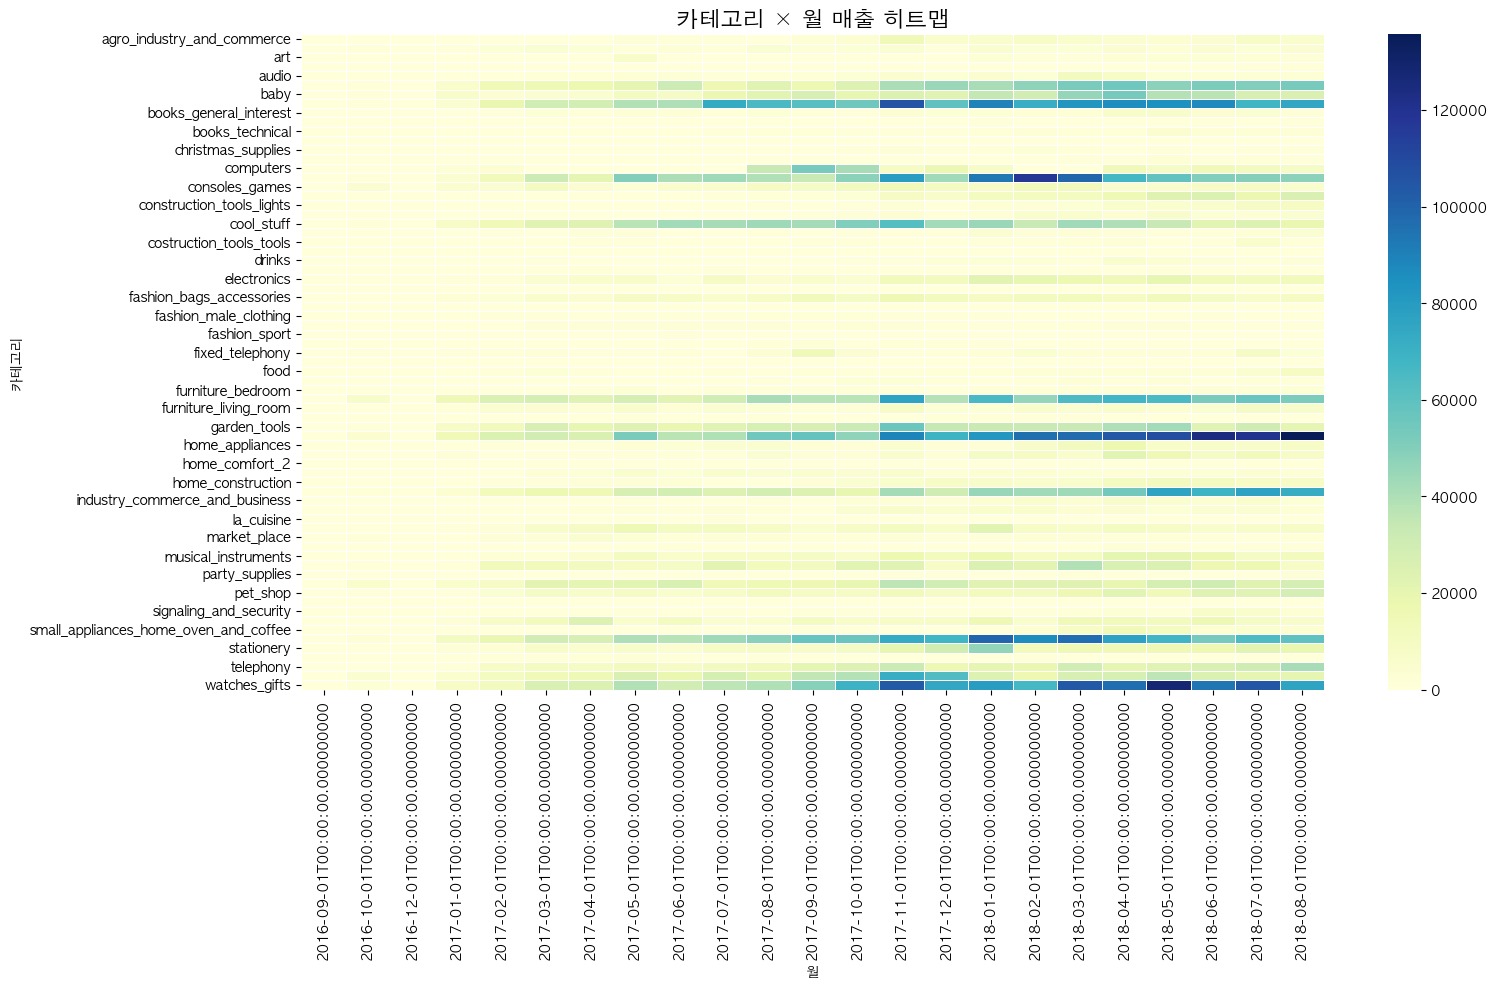

In [8]:
# ============================================
# Olist – 과제3 EDA Workflow (최종 정리)
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose

# ------------------------------------------------
# 1. 데이터 불러오기 (CSV → DataFrame)
# ------------------------------------------------
orders       = pd.read_csv("olist_orders_dataset.csv")
customers    = pd.read_csv("olist_customers_dataset.csv")
items        = pd.read_csv("olist_order_items_dataset.csv")
payments     = pd.read_csv("olist_order_payments_dataset.csv")
reviews      = pd.read_csv("olist_order_reviews_dataset.csv")
products     = pd.read_csv("olist_products_dataset.csv")
sellers      = pd.read_csv("olist_sellers_dataset.csv")
geolocation  = pd.read_csv("olist_geolocation_dataset.csv")
translation  = pd.read_csv("product_category_name_translation.csv")

print("✅ 데이터 로드 완료")

# ------------------------------------------------
# 2. 품질 점검 (Quality Check)
# ------------------------------------------------
print("\n[결측치 확인]")
print(pd.DataFrame({
    'orders': orders.isna().sum(),
    'items': items.isna().sum(),
    'products': products.isna().sum(),
    'translation': translation.isna().sum()
}).fillna('-'))

print("\n[중복 여부 확인]")
print("orders 중복:", orders.duplicated().sum())
print("items 중복:", items.duplicated().sum())
print("products 중복:", products.duplicated().sum())

# ------------------------------------------------
# 3. 전처리
# ------------------------------------------------
# 3-1) 날짜 파싱
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# 3-2) 주문 상태 delivered만 남기기
orders = orders[orders['order_status'] == 'delivered']

# 3-3) products + translation merge (포르투갈어 → 영어 카테고리)
products = products.merge(translation, on='product_category_name', how='left')

# 3-4) items + products merge (카테고리 붙이기)
order_items = items.merge(
    products[['product_id', 'product_category_name_english']],
    on='product_id', how='left'
)

# 3-5) 수요 산출
order_items['quantity'] = 1
order_items['revenue'] = order_items['price'] + order_items['freight_value']

print("\n✅ 전처리 완료")

# ------------------------------------------------
# 4. 월별·카테고리별 패널 생성
# ------------------------------------------------
panel = order_items.merge(
    orders[['order_id', 'order_month']],
    on='order_id', how='left'
)

monthly_category = (
    panel.groupby(['order_month', 'product_category_name_english'])
         .agg(quantity=('quantity','sum'),
              revenue=('revenue','sum'))
         .reset_index()
)

# order_month를 datetime으로 변환
monthly_category['order_month'] = monthly_category['order_month'].dt.to_timestamp()

print("\n✅ 월별·카테고리별 패널 생성 완료")
print(monthly_category.head())

# ------------------------------------------------
# 5. 탐색적 시각화 (EDA)
# ------------------------------------------------
# Top-N 카테고리
top_n = 10
top_categories = (monthly_category.groupby('product_category_name_english')['revenue']
                  .sum()
                  .sort_values(ascending=False)
                  .head(top_n)
                  .index)

# 판매량 라인플롯
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_category[monthly_category['product_category_name_english'].isin(top_categories)],
             x='order_month', y='quantity', hue='product_category_name_english', marker="o")
plt.title(f"Top {top_n} 카테고리 월별 판매량 추세", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("월")
plt.ylabel("판매량 (Quantity)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 매출 라인플롯
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_category[monthly_category['product_category_name_english'].isin(top_categories)],
             x='order_month', y='revenue', hue='product_category_name_english', marker="o")
plt.title(f"Top {top_n} 카테고리 월별 매출 추세", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("월")
plt.ylabel("매출 (Revenue)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 성장/하락 카테고리 식별
slopes = {}
for cat in monthly_category['product_category_name_english'].dropna().unique():
    df_cat = monthly_category[monthly_category['product_category_name_english']==cat].sort_values('order_month')
    if len(df_cat) >= 3:
        x = range(len(df_cat))
        y = df_cat['revenue'].values
        slope, _, _, _, _ = linregress(x, y)
        slopes[cat] = slope

growth_cats = sorted(slopes.items(), key=lambda x: x[1], reverse=True)[:5]
decline_cats = sorted(slopes.items(), key=lambda x: x[1])[:5]

print("📈 성장 카테고리 TOP5:", growth_cats)
print("📉 하락 카테고리 TOP5:", decline_cats)

# 히트맵
pivot_table = monthly_category.pivot_table(
    index='product_category_name_english',
    columns='order_month',
    values='revenue',
    aggfunc='sum'
).fillna(0)

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=0.5)
plt.title("카테고리 × 월 매출 히트맵", fontsize=16)
plt.xlabel("월")
plt.ylabel("카테고리")
plt.tight_layout()
plt.show()


관측(Non-NaN) 개수: 21, 전체 length (포함 결측): 23
충분한 연간 주기 관측치 없음 (필요: 24, 현재: 21). 대체 방법을 사용합니다.
대체 period = 10 로 seasonal_decompose (additive) 시도 (해석 주의) ...


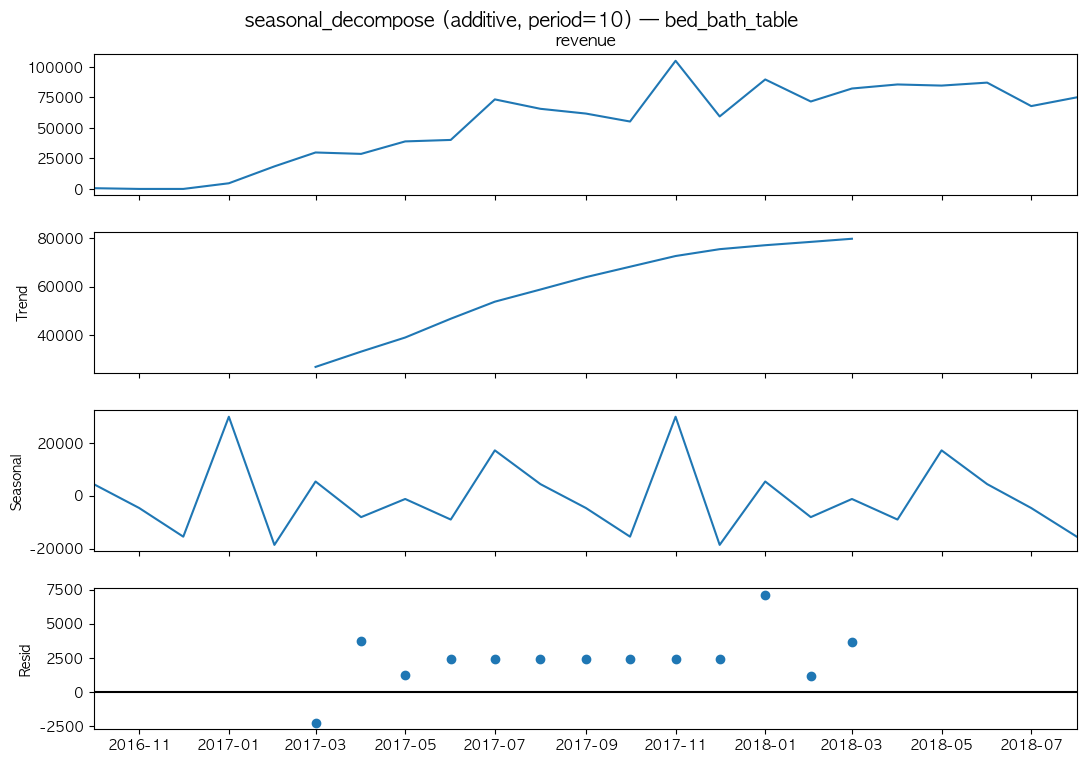

In [9]:
# ------------------------------------------------
# 6. 계절성/패턴 탐색 (시계열 분해 예시)
# ------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# 분석할 카테고리 지정
category = "bed_bath_table"

# monthly_category 가 이미 존재한다고 가정
# (컬럼명: 'order_month' (datetime), 'product_category_name_english', 'revenue')
cat_df = monthly_category[monthly_category['product_category_name_english'] == category].copy()

# 1) 월별로 집계 (안전하게)
cat_df = cat_df.groupby('order_month', as_index=False)['revenue'].sum()

# 2) 인덱스를 Datetime으로 만들고 월 단위 freq 지정
cat_df['order_month'] = pd.to_datetime(cat_df['order_month'])
ts = cat_df.set_index('order_month')['revenue'].asfreq('MS')  # Monthly Start frequency

# 3) 관측치 수 확인
n_obs_nonan = ts.dropna().shape[0]
n_total = len(ts)
print(f"관측(Non-NaN) 개수: {n_obs_nonan}, 전체 length (포함 결측): {n_total}")

# 4) 기본 연간 주기
annual_period = 12

# 5) 시도 로직
if n_obs_nonan >= 2 * annual_period:
    print("충분한 관측치(>=24) 발견 — seasonal_decompose(period=12, model='multiplicative') 실행")
    ts_use = ts.fillna(0.0)            # 결측은 0으로 채우거나 다른 전략 가능
    result = seasonal_decompose(ts_use, model='multiplicative', period=annual_period)
    fig = result.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f"seasonal_decompose (multiplicative) — {category}", fontsize=14)
    plt.show()

else:
    print(f"충분한 연간 주기 관측치 없음 (필요: 24, 현재: {n_obs_nonan}). 대체 방법을 사용합니다.")
    # 대체 1: fallback_period를 쓰는 seasonal_decompose (주의: 해석에 유의)
    fallback_period = max(2, n_obs_nonan // 2)  # 적어도 2로 설정
    print(f"대체 period = {fallback_period} 로 seasonal_decompose (additive) 시도 (해석 주의) ...")
    try:
        ts_use = ts.fillna(0.0)
        result = seasonal_decompose(ts_use, model='additive', period=fallback_period)
        fig = result.plot()
        fig.set_size_inches(12, 8)
        plt.suptitle(f"seasonal_decompose (additive, period={fallback_period}) — {category}", fontsize=14)
        plt.show()
    except Exception as e:
        print("seasonal_decompose (fallback) 실패:", e)
        print("대신 STL 분해를 시도합니다 (더 유연).")
        try:
            # STL: 결측은 평균으로 채우고 robust=True 로 잡음에 강하게 함
            ts_stl = ts.fillna(ts.mean())
            # STL의 period는 모델 목적에 맞게 선택. 여기서는 min(12, fallback_period) 권장
            stl_period = min(12, max(3, fallback_period))
            stl = STL(ts_stl, period=stl_period, robust=True)
            res = stl.fit()
            res.plot()
            plt.suptitle(f"STL decomposition (period={stl_period}) — {category}", fontsize=14)
            plt.show()
        except Exception as e2:
            print("STL 분해도 실패했습니다:", e2)
            print("마지막으로 Prophet 또는 다른 방법(모델 기반 예측)을 권장합니다.")


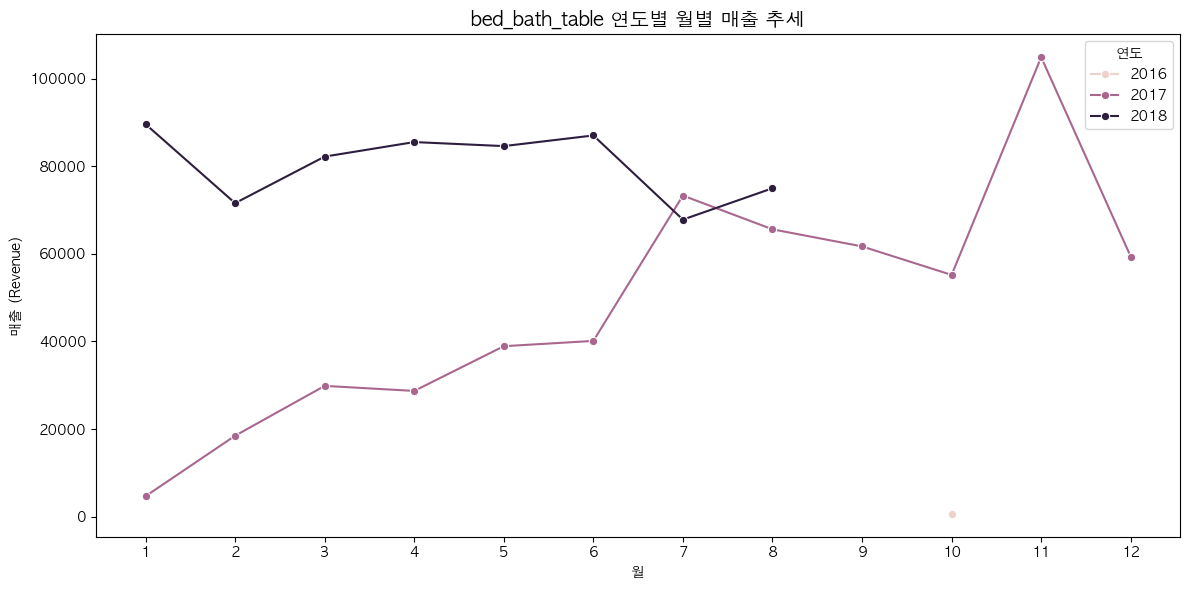

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# monthly_category가 이미 존재한다고 가정
# 컬럼명: 'order_month' (datetime), 'product_category_name_english', 'revenue'
category = "bed_bath_table"
cat_df = monthly_category[monthly_category['product_category_name_english'] == category].copy()

# 연도와 월 추출
cat_df['year'] = cat_df['order_month'].dt.year
cat_df['month'] = cat_df['order_month'].dt.month

# 연도별 월별 매출 집계
cat_year_month = cat_df.groupby(['year', 'month'], as_index=False)['revenue'].sum()

# 연도별 그래프 그리기
plt.figure(figsize=(12, 6))
sns.lineplot(data=cat_year_month, x='month', y='revenue', hue='year', marker='o')
plt.title(f"{category} 연도별 월별 매출 추세", fontsize=14)
plt.xlabel("월")
plt.ylabel("매출 (Revenue)")
plt.xticks(range(1,13))
plt.legend(title="연도")
plt.tight_layout()
plt.show()

## 수요 예측 

1.	asfreq('MS') → 월 단위 시계열로 변환
2.	Train/Test Split → 마지막 12개월을 Test로 사용
3.	Seasonal Naive → 이전 연도의 같은 달 매출 그대로 예측
4.	MAE 계산 → sklearn.metrics.mean_absolute_error
5.	시각화 → Train/Test/Forecast 비교

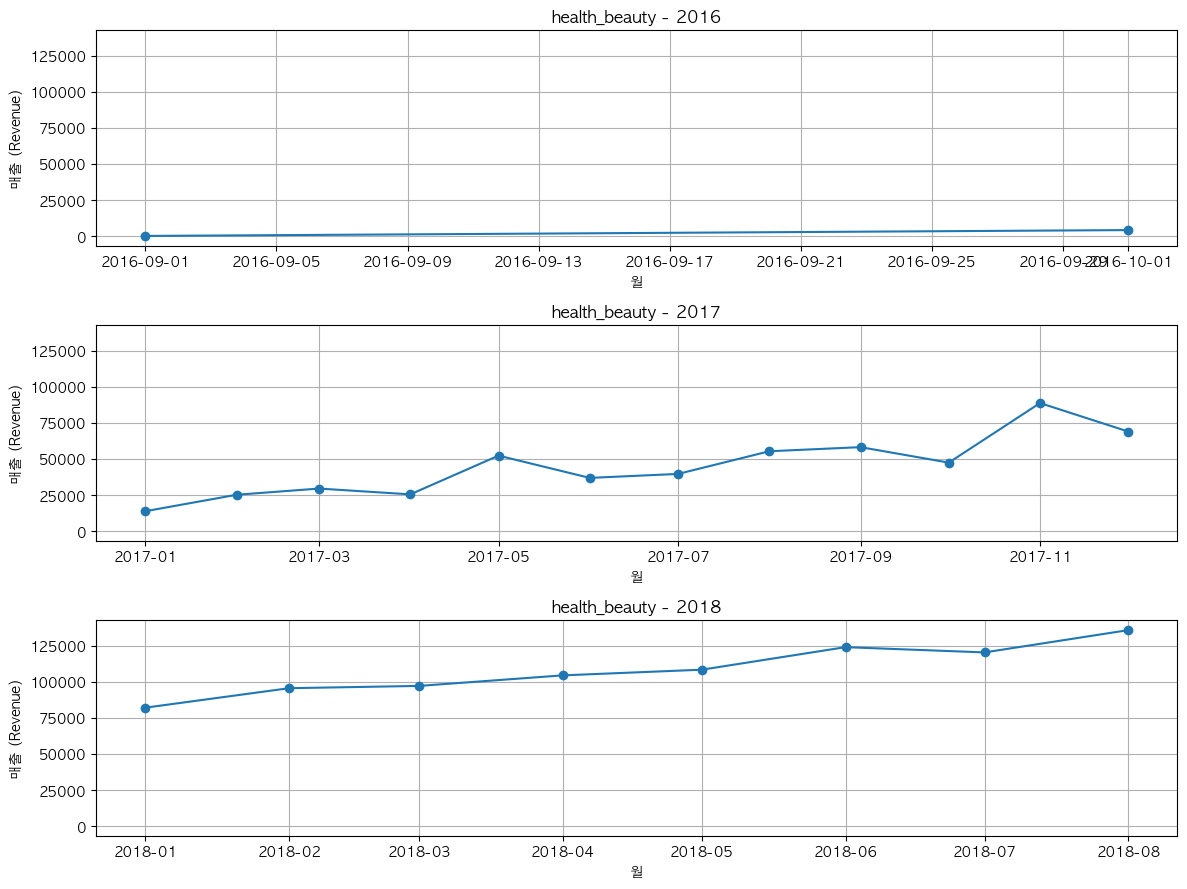

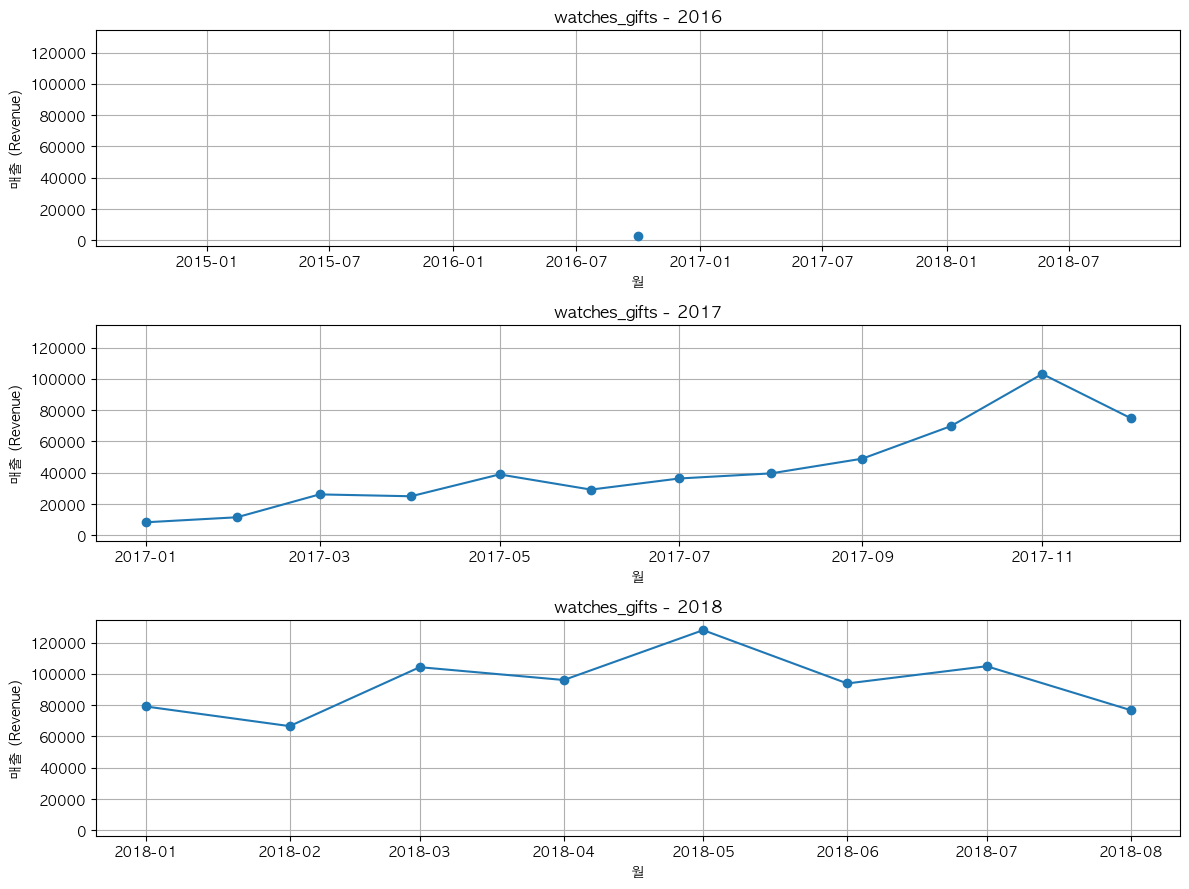

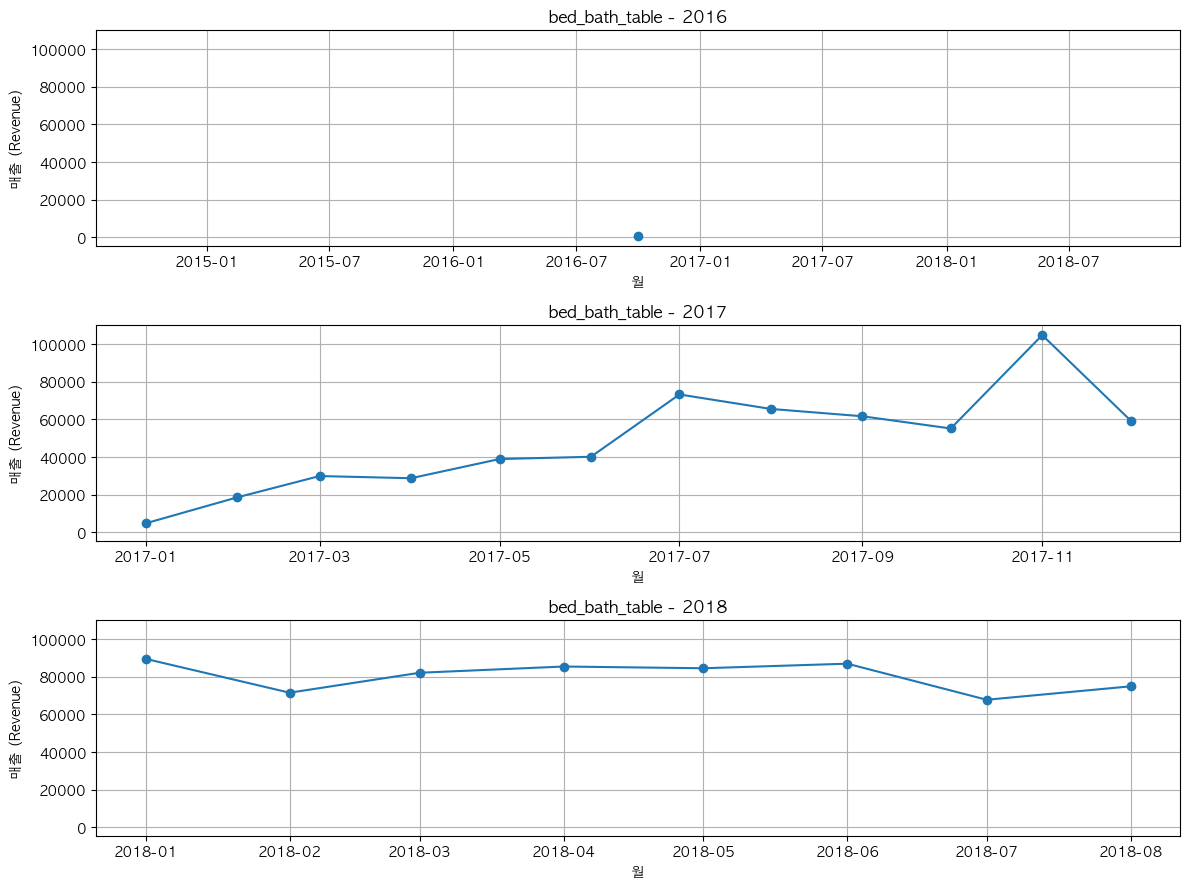

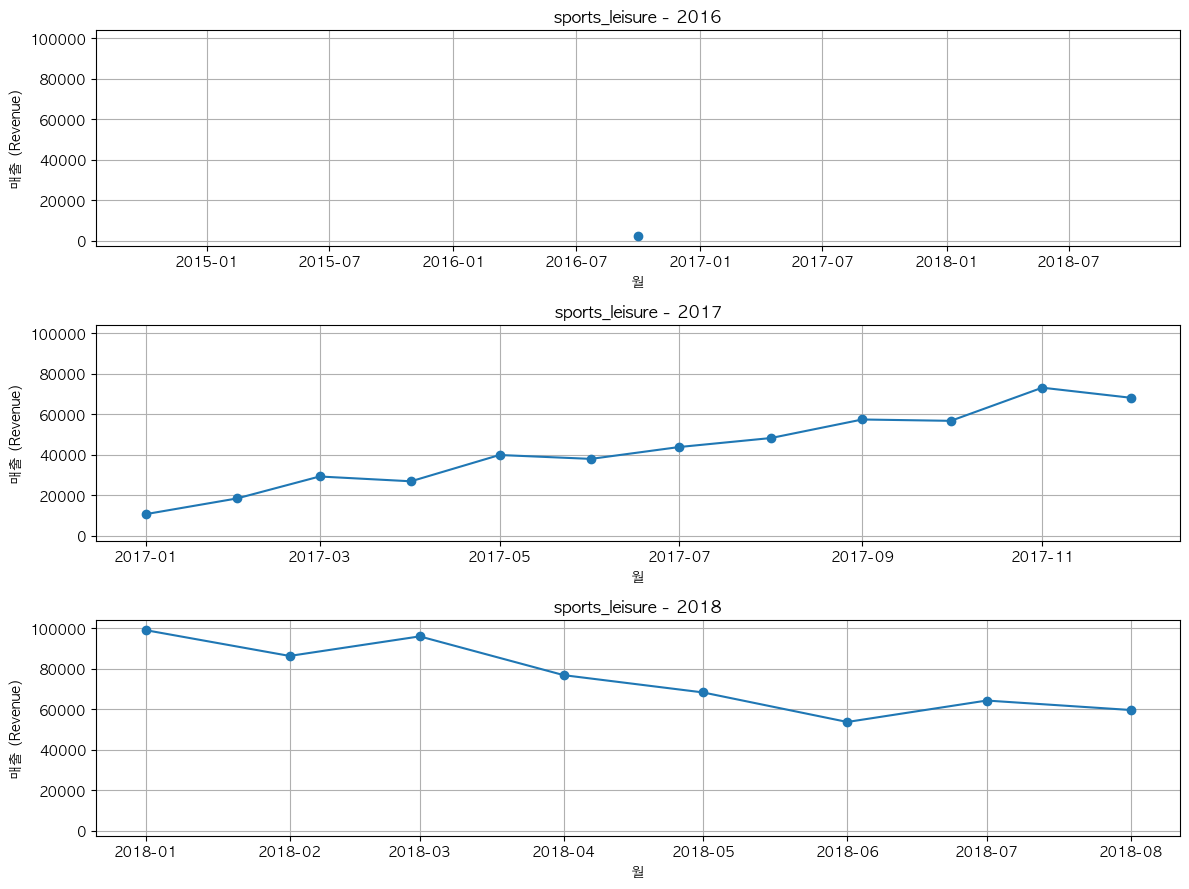

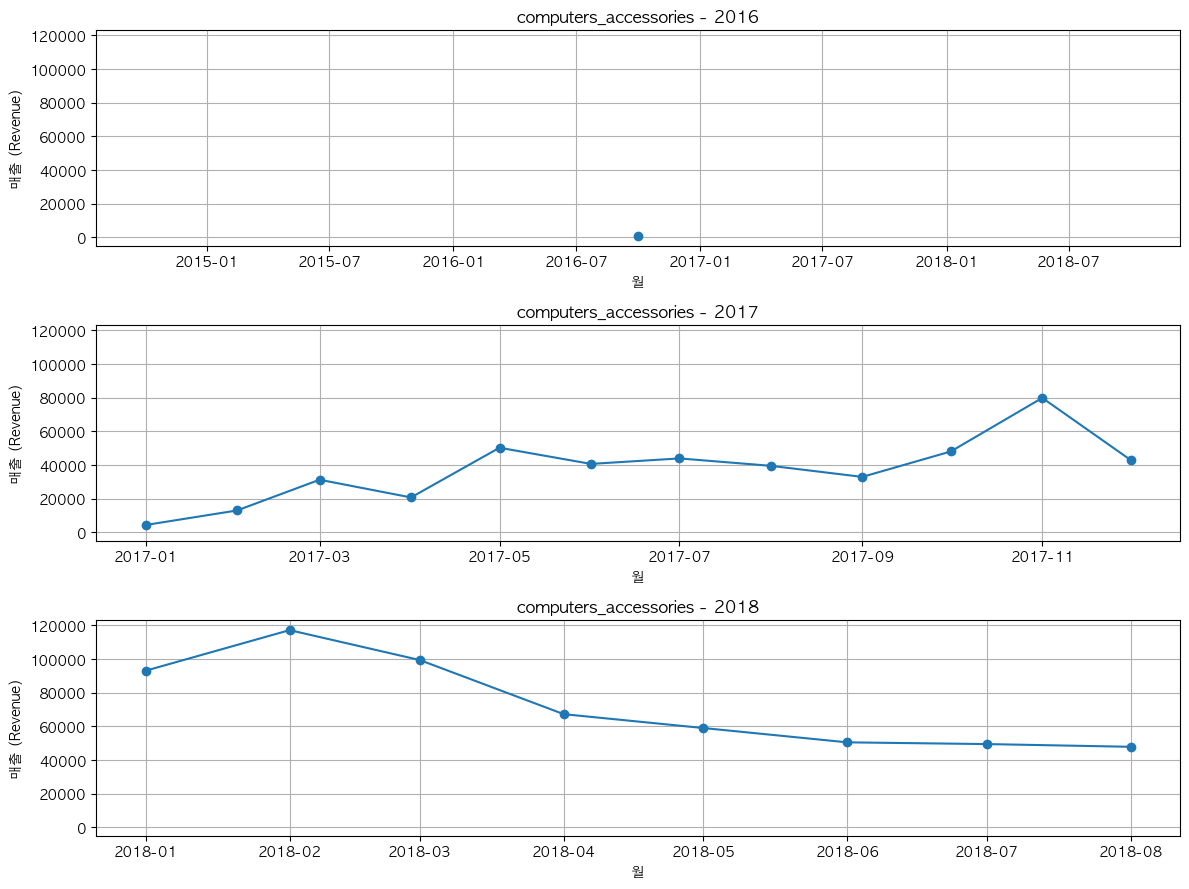

Top-N 카테고리 Seasonal Naive Forecast MAE 요약
                category           MAE
4  computers_accessories  41965.706667
3         sports_leisure  46117.621667
2         bed_bath_table  46584.960000
1          watches_gifts  65763.269167
0          health_beauty  70640.105833


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Top-N 카테고리 선택
top_n = 5
top_categories = (monthly_category.groupby('product_category_name_english')['revenue']
                  .sum()
                  .sort_values(ascending=False)
                  .head(top_n)
                  .index)

results = []

for category in top_categories:
    cat_df = monthly_category[monthly_category['product_category_name_english'] == category].copy()
    
    # 월별 매출 집계
    cat_monthly = cat_df.groupby('order_month', as_index=False)['revenue'].sum()
    cat_monthly.set_index('order_month', inplace=True)
    cat_monthly = cat_monthly.asfreq('MS')  # Monthly Start
    
    # Train / Test Split (마지막 12개월 test)
    train = cat_monthly.iloc[:-12]
    test  = cat_monthly.iloc[-12:]
    
    # Seasonal Naive Forecast
    seasonal_naive_forecast = train['revenue'][-12:].values if len(train) >= 12 else train['revenue'].values
    
    # Test 길이에 맞게 조정
    n = min(len(test), len(seasonal_naive_forecast))
    forecast = pd.Series(seasonal_naive_forecast[-n:], index=test.index[-n:])
    
    # Test / Forecast NaN 처리
    y_true = test['revenue'].fillna(0)
    y_pred = forecast.fillna(0)
    
    # Seasonal Naive Forecast
    if len(train) >= 12:
        seasonal_naive_forecast = train['revenue'][-12:].values
    else:
        seasonal_naive_forecast = train['revenue'].values

    # 테스트 길이에 맞게 조정
    n = len(test)
    forecast = pd.Series(
        list(seasonal_naive_forecast[-n:]) + [seasonal_naive_forecast[-1]]*(n - len(seasonal_naive_forecast)),
        index=test.index
    )

    # NaN 제거 후 MAE 계산
    y_true = test['revenue'].fillna(0)
    y_pred = forecast.fillna(0)

    mae = mean_absolute_error(y_true, y_pred)
    results.append({'category': category, 'MAE': mae})
    
    # -----------------------------
    # 연도별 시각화
    # -----------------------------
    cat_monthly['year'] = cat_monthly.index.year
    years = cat_monthly['year'].unique()
    n_years = len(years)
    
    fig, axes = plt.subplots(n_years, 1, figsize=(12, 3*n_years), sharey=True)
    
    if n_years == 1:
        axes = [axes]  # 1년이면 list로 통일
    
    for ax, year in zip(axes, years):
        data = cat_monthly[cat_monthly['year'] == year]
        ax.plot(data.index, data['revenue'], marker='o', label=f'{year} Revenue')
        ax.set_title(f"{category} - {year}", fontsize=12)
        ax.set_xlabel("월")
        ax.set_ylabel("매출 (Revenue)")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# 결과 요약
results_df = pd.DataFrame(results).sort_values('MAE')
print("Top-N 카테고리 Seasonal Naive Forecast MAE 요약")
print(results_df)

### 실제 수요, 예측, 안전재고 발주량 확인 
1.	mean_demand / std_demand → 과거 12개월 기준 수요 평균과 표준편차 계산
2.	safety_stock → 서비스 수준(Z)과 수요 변동성, 리드타임 반영
3.	forecast → Seasonal Naive Forecast (작년 같은 달 수요)
4.	recommended_order → forecast + safety_stock
5.	그래프 → 실제 수요, 예측, 안전재고, 발주량 한눈에 확인

/var/folders/98/vj3q9b254k79y681ng12dddh0000gn/T/ipykernel_55551/2514307645.py:62: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(monthly_category_panel['order_month']):


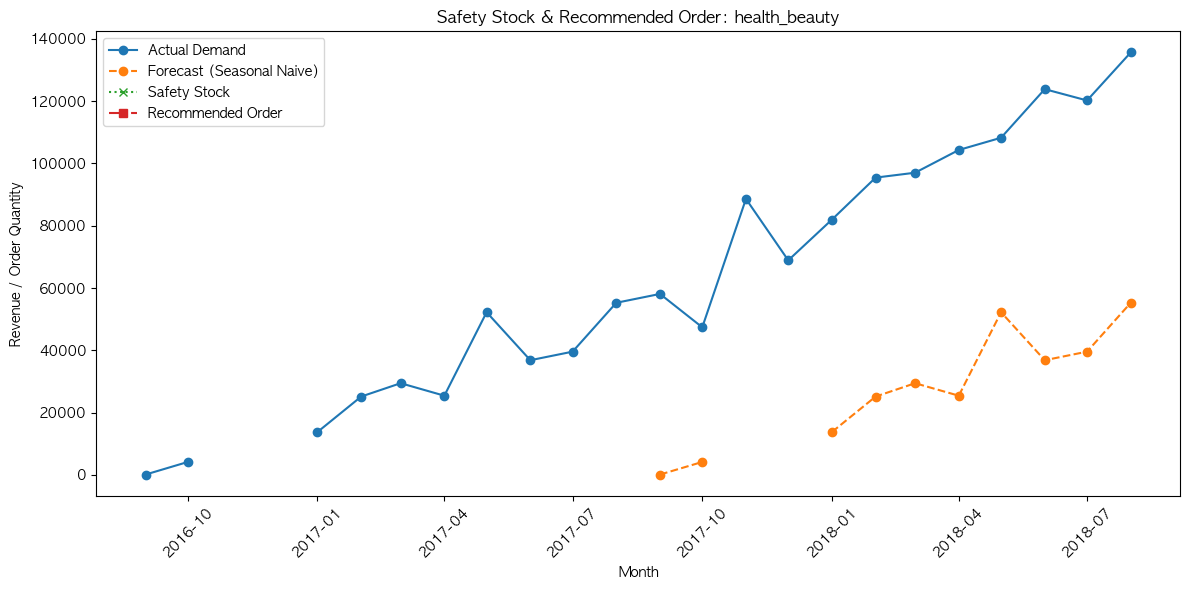

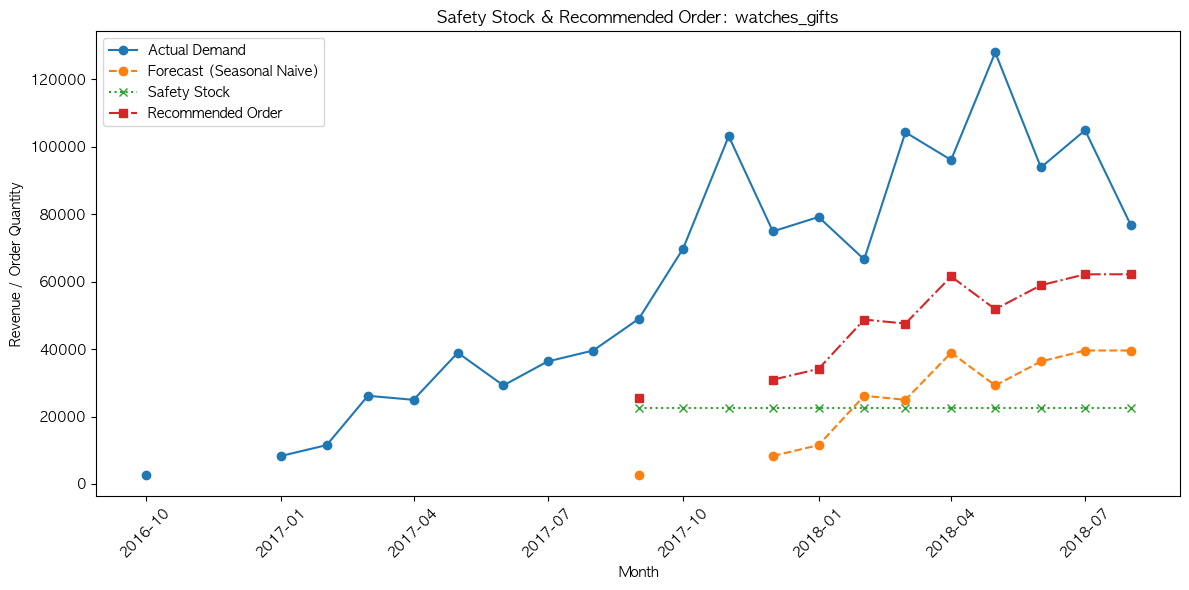

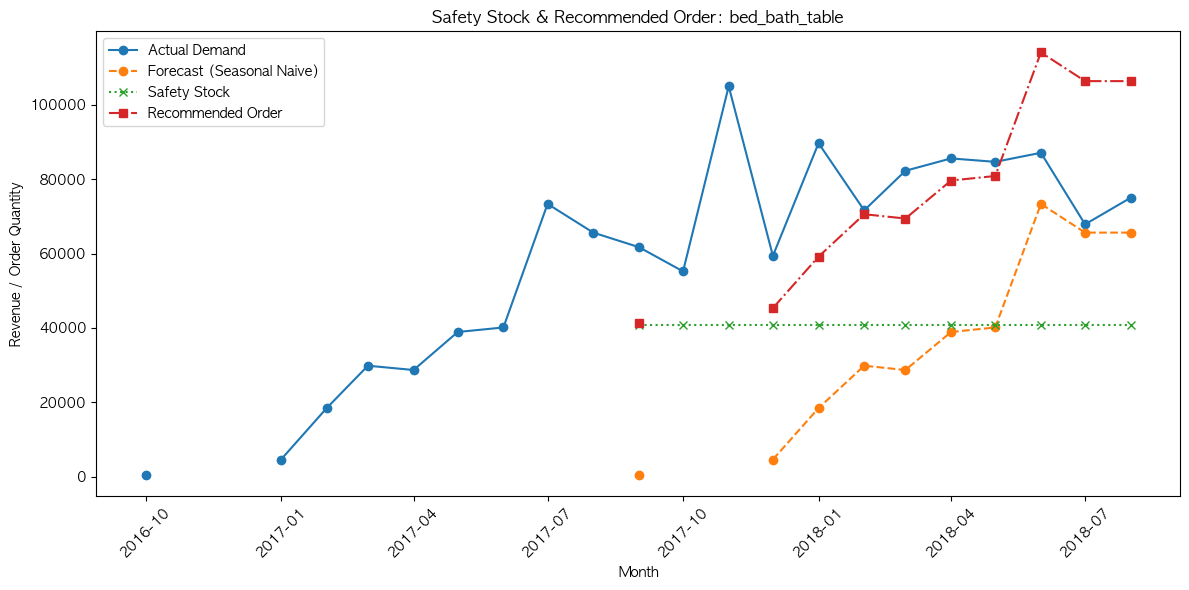

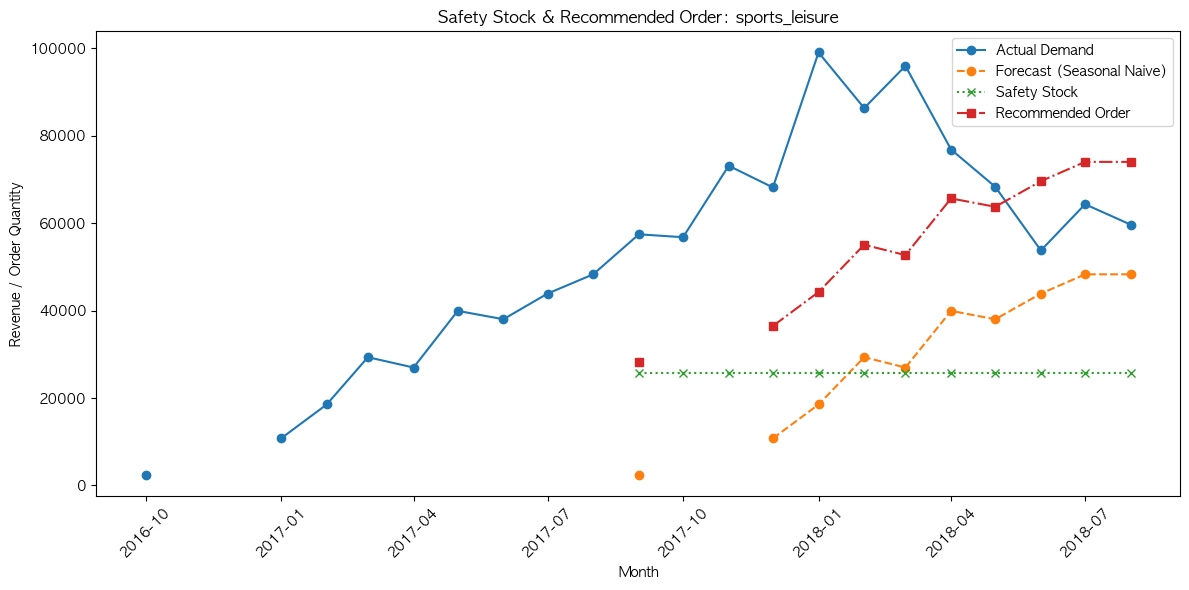

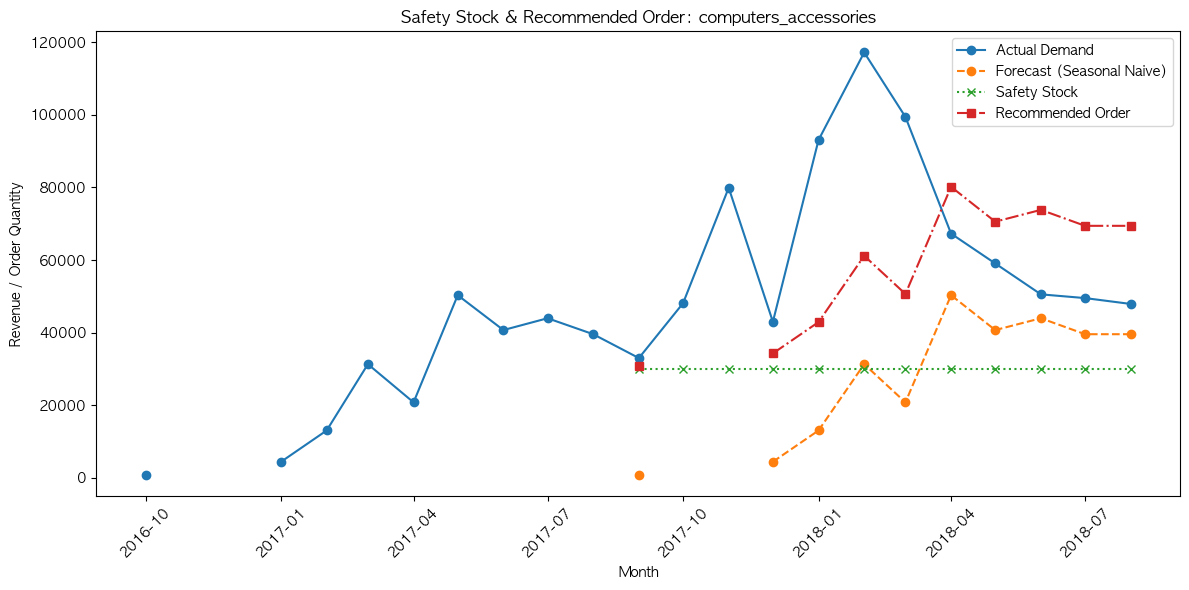

Top-N 카테고리 Seasonal Naive Forecast MAE 요약
                category           MAE
4  computers_accessories  41965.706667
3         sports_leisure  46117.621667
2         bed_bath_table  46584.960000
1          watches_gifts  65763.269167
0          health_beauty  70640.105833


In [12]:
# ============================================
# Olist – EDA + Forecast + Safety Stock (완전 워크플로우)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# ------------------------------------------------
# 1. CSV 불러오기
# ------------------------------------------------
orders       = pd.read_csv("olist_orders_dataset.csv")
items        = pd.read_csv("olist_order_items_dataset.csv")
products     = pd.read_csv("olist_products_dataset.csv")
category_map = pd.read_csv("product_category_name_translation.csv")

# ------------------------------------------------
# 2. 전처리
# ------------------------------------------------
# 날짜 파싱
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# delivered 상태만 필터링
orders = orders[orders['order_status'] == 'delivered']

# product_category_name_english 생성 (category_map 활용)
if 'product_category_name_english' not in products.columns:
    products = products.merge(category_map, on='product_category_name', how='left')

# 안전하게 컬럼명 통일
products.rename(columns={'product_category_name_english':'category_english'}, inplace=True)

# 주문 아이템 + 카테고리 결합
order_items = items.merge(
    products[['product_id', 'category_english']],
    on='product_id', how='left'
)

# 수요 산출
order_items['quantity'] = 1
order_items['revenue']  = order_items['price'] + order_items['freight_value']

# ------------------------------------------------
# 3. 월별·카테고리별 패널 생성
# ------------------------------------------------
panel = order_items.merge(
    orders[['order_id','order_month']],
    on='order_id', how='left'
)

monthly_category_panel = (
    panel.groupby(['order_month','category_english'])
         .agg(quantity=('quantity','sum'),
              revenue=('revenue','sum'))
         .reset_index()
)

# order_month -> Timestamp
if pd.api.types.is_period_dtype(monthly_category_panel['order_month']):
    monthly_category_panel['order_month'] = monthly_category_panel['order_month'].dt.to_timestamp()

monthly_category_panel['category_english'] = monthly_category_panel['category_english'].fillna('Unknown')

# ------------------------------------------------
# 4. Top-N 카테고리 선정
# ------------------------------------------------
top_n = 5
top_categories = (monthly_category_panel.groupby('category_english')['revenue']
                  .sum()
                  .sort_values(ascending=False)
                  .head(top_n)
                  .index)

# ------------------------------------------------
# 5. Forecast + 안전재고 + 추천 발주량 시각화
# ------------------------------------------------
results = []

for category in top_categories:
    cat_df = monthly_category_panel[monthly_category_panel['category_english']==category].copy()
    cat_df = cat_df.groupby('order_month', as_index=False)['revenue'].sum()
    cat_df.set_index('order_month', inplace=True)
    cat_df = cat_df.asfreq('MS')  # Monthly Start
    
    # Train/Test Split (마지막 12개월)
    train = cat_df.iloc[:-12]
    test  = cat_df.iloc[-12:]
    
    # Seasonal Naive Forecast
    if len(train) >= 12:
        seasonal_naive_forecast = train['revenue'][-12:].values
    else:
        seasonal_naive_forecast = train['revenue'].values
    
    # Test 길이에 맞게 조정
   
    # Test 길이에 맞게 조정
    n = min(len(test), len(seasonal_naive_forecast))
    forecast = pd.Series(seasonal_naive_forecast[-n:], index=test.index[-n:])
    
    # Test / Forecast NaN 처리
    y_true = test['revenue'].fillna(0)
    y_pred = forecast.fillna(0)
    
    # Seasonal Naive Forecast
    if len(train) >= 12:
        seasonal_naive_forecast = train['revenue'][-12:].values
    else:
        seasonal_naive_forecast = train['revenue'].values

    # 테스트 길이에 맞게 조정
    n = len(test)
    forecast = pd.Series(
        list(seasonal_naive_forecast[-n:]) + [seasonal_naive_forecast[-1]]*(n - len(seasonal_naive_forecast)),
        index=test.index
    )
    
    # NaN 처리
    y_true = test['revenue'].fillna(0)
    y_pred = forecast.fillna(0)
    
    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)
    results.append({'category': category, 'MAE': mae})
    
    # 안전재고 계산 (최근 12개월 std * 1.65)
    if len(train) >= 12:
        safety_stock_val = train['revenue'].rolling(12).std().iloc[-1]*1.65
    else:
        safety_stock_val = train['revenue'].std()*1.65
    safety_stock = pd.Series(safety_stock_val, index=test.index)
    
    # 추천 발주량 = forecast + safety_stock
    recommended_order = forecast + safety_stock
    
    # DatetimeIndex 확인
    cat_df.index = pd.to_datetime(cat_df.index)
    forecast.index = pd.to_datetime(forecast.index)
    safety_stock.index = pd.to_datetime(safety_stock.index)
    recommended_order.index = pd.to_datetime(recommended_order.index)
    
    # 시각화
    plt.figure(figsize=(12,6))
    plt.plot(cat_df.index, cat_df['revenue'], label='Actual Demand', marker='o')
    plt.plot(forecast.index, forecast, label='Forecast (Seasonal Naive)', marker='o', linestyle='--')
    plt.plot(safety_stock.index, safety_stock, label='Safety Stock', marker='x', linestyle=':')
    plt.plot(recommended_order.index, recommended_order, label='Recommended Order', marker='s', linestyle='-.')
    plt.title(f"Safety Stock & Recommended Order: {category}")
    plt.xlabel("Month")
    plt.ylabel("Revenue / Order Quantity")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# 6. 결과 요약
# ------------------------------------------------
results_df = pd.DataFrame(results).sort_values('MAE')
print("Top-N 카테고리 Seasonal Naive Forecast MAE 요약")
print(results_df)